In [1]:
pip install --upgrade google-cloud-storage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install --upgrade google-cloud-speech

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install --upgrade firebase-admin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
from google.cloud import storage
from google.cloud import speech
import pprint
from textblob.sentiments import NaiveBayesAnalyzer
import textblob
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [5]:
#Constants
BUCKET_NAME = "speech_to_text_admn5015"

In [7]:
#Create Environment Variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/essential-rider-375921-74f005818646.json"
cred = credentials.Certificate("/content/essential-rider-375921-74f005818646.json")
app = firebase_admin.initialize_app(cred)


This is the uri: gs://speech_to_text_admn5015/Handling Sales Calls - Speaking English Fluently.wav
Waiting for operation to complete...

Transcript: welcome to 2 minute English, teaching you English in 2 minutes or less is this lesson we will tell you how to handle sales calls from different Institution
Confidence: 0.9406661987304688
Sentiment polarity:0.12666666666666668
Sentiment magnitude:0.03968888888888889
Document suegbBCceBX2x8FmSK4w created

Transcript:  hello am I speaking with Jim this is Mike calling on behalf of Signature Bank in 45 years
Confidence: 0.8939522504806519
Sentiment polarity:0.0
Sentiment magnitude:0.0
Document Ii4AipTN8GW0znojBcH2 created

Transcript:  that's right what's this about a higher interest rate if you open a savings account with Signature Bank
Confidence: 0.9529316425323486
Sentiment polarity:0.17857142857142858
Sentiment magnitude:0.09141156462585033
Document mgkFuVYUmQghlBUlBZWH created

Transcript:  now I'm found my current status are you sure t

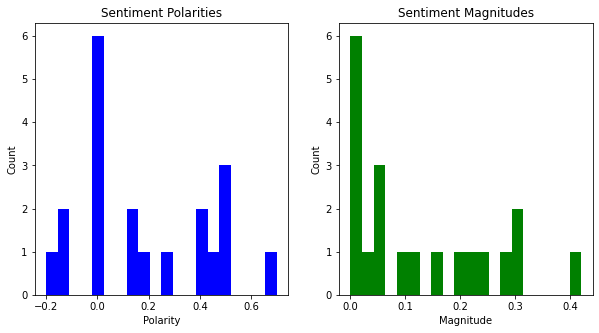

In [10]:
from google.cloud import storage


def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    # bucket_name = "your-bucket-name"

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)

    return blobs

    # # Note: The call returns a response only when the iterator is consumed.
    # for blob in blobs:
    #     print(blob.name)

def extract_audio_gcs(gcs_uri):
    """Asynchronously transcribes the audio file specified by the gcs_uri."""

    client = speech.SpeechClient()

    audio = speech.RecognitionAudio(uri=gcs_uri)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        audio_channel_count=2,
        language_code="en-US",
    )

    operation = client.long_running_recognize(config=config, audio=audio)

    print("Waiting for operation to complete...")
    response = operation.result(timeout=600)

    return response

#Analyzes the sentiment of the transcription using TextBlob.
def analyze_sentiment(transcription):
    
    blob = TextBlob(transcription)
    sentiment = blob.sentiment
    return sentiment
import matplotlib.pyplot as plt

#Visualizing the sentiments polarities and magnitudes in bar graphs
def plot_sentiment(senti):
    """Plots the sentiment polarities and magnitudes."""
    
    polarities = [s[0] for s in senti]
    magnitudes = [s[1] for s in senti]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.hist(polarities, bins=20, color='blue')
    ax1.set_title('Sentiment Polarities')
    ax1.set_xlabel('Polarity')
    ax1.set_ylabel('Count')

    ax2.hist(magnitudes, bins=20, color='green')
    ax2.set_title('Sentiment Magnitudes')
    ax2.set_xlabel('Magnitude')
    ax2.set_ylabel('Count')

    plt.show()

def save_to_db(number,transcript,sentiment,magnitude):
    # TODO: save to db

    db = firestore.client()    
    doc_ref = db.collection(u'Speech-to-text').document()
    doc_ref.set({
        u'wav_filename': u'Handling Sales Calls - Speaking English Fluently.wav',
        u'sentence_number': number,
        u'sentence_text': transcript,
        u'sentiment': sentiment,
        u'magnitude': magnitude,
        u'transcription_date': '2023-02-15'
    })
    print('Document {} created'.format(doc_ref.id))

def main():
  blobs = list_blobs(BUCKET_NAME)
  senti = []
#Extract Audio from Each file
  for blob in blobs:
    gcs_uri = "gs://" + BUCKET_NAME + "/" + blob.name
    print("\nThis is the uri: {}".format(gcs_uri))

    response = extract_audio_gcs(gcs_uri=gcs_uri)
    count = 0
  for result in response.results:
      transcript = result.alternatives[0].transcript
      print("\nTranscript: {}".format(result.alternatives[0].transcript))
      print("Confidence: {}".format(result.alternatives[0].confidence))

  #Sentiment Analysis performed for the audio transcript
      sentiment = analyze_sentiment(transcript)
      polarity = sentiment.polarity
      magnitude = abs(polarity) * sentiment.subjectivity
            
      print("Sentiment polarity:{}".format(polarity))
      print("Sentiment magnitude:{}".format(magnitude))
      
      senti.append((polarity, magnitude))
      save_to_db(count,transcript, polarity , magnitude)
      count +=1
  #plotting results from sentiments          
  plot_sentiment(senti)
        
if __name__ =="__main__":
  main()

1. Since the audio file consists of various customer service calls audio clipings, so sentimental analysis cannot determine the change in customer experience over time. 

2. However, I performed the sentimental analysis on each transcript tuple and appended into a list to gauge the overall performance of the call center

3. After ploting the results on the histogram using matplotlib we can see that the most of the conversation depicted a nuetral sentiments from the consumer.
